In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import sklearn.preprocessing

In [2]:
# env definition
env_name = "MountainCar-v0"
env = gym.make(env_name)
J=20
obs = env.reset()
sample_count = 20000
obs_samples = [env.observation_space.sample() for _ in range(sample_count)]
kmeans = KMeans(J, random_state=0).fit(obs_samples)
sigma = np.std(obs_samples)
scaler = sklearn.preprocessing.StandardScaler().fit(obs_samples)

# Observation:
## Type: Box(2) from official documentation of mountain car
        Num    Observation               Min            Max
        0      Car Position              -1.2           0.6
        1      Car Velocity              -0.07          0.07

In [3]:
# basis function in rbf
def gaussian_like_basis(x,mean,sigma):
    return np.exp(-np.linalg.norm(x - mean)/sigma)

In [4]:
# design matrix (X_data.shape[0] * J)
def design_matrix(X_data, J):
    global kmeans, sigma   
    U = np.zeros((1, J))
    for j in range(J):
        U[0][j] = gaussian_like_basis(X_data, kmeans.cluster_centers_[j], sigma)
    return U

In [5]:
# Quantize the states (discretize the state
def discretization(obs):
    n_states = 40
    env_low = env.observation_space.low
    env_high = env.observation_space.high
    env_den = (env_high - env_low) / n_states
    pos_den = env_den[0]
    vel_den = env_den[1]
    pos_high = env_high[0]
    pos_low = env_low[0]
    vel_high = env_high[1]
    vel_low = env_low[1]
    pos_scaled = int((obs[0] - pos_low) / pos_den)
    vel_scaled = int((obs[1] - vel_low) / vel_den)
    return pos_scaled, vel_scaled

In [6]:
def mini_RBF(observation):
    global scaler
    J = 20
    position, velocity = scaler.transform([observation])[0]
    x = np.asarray([position, velocity])
    return design_matrix(x, J)

In [7]:
def Q_state_update(weight, state, action=None):
    if action != None:
        return np.dot(state, weight[:, int(action)])        
    else:
        return np.dot(state, weight)

In [8]:
def policy(weight, state):
    return np.argmax([Q_state_update(weight, state, action) for action in range(env.action_space.n)])

def w_GD(weight, X_data, y):
    return (- 1 * len(X_data)) * np.dot(X_data.T, (y - np.dot(X_data, weight)))

In [9]:
q_train_steps = []
def q_climb_hill():
    print("Q is helping car climb the mountain!")
    J = 20
    
    
    
    #  Switching on image engine will slow down the process
    global env
#     env.render()
    # Some initializations
    n_states = 40
    episodes = 50
    initial_lr = 1.0
    min_lr = 0.005
    gamma = 0.99
    max_stps = 300
    epsilon = 0.08
    env = env.unwrapped
    env.seed()
    np.random.seed(0)
    
    w = np.random.randn(J, env.action_space.n)
    # print("w.shape:", w.shape)
    
    for episode in range(episodes):
        step = 0
        obs = env.reset()
        state = mini_RBF(obs)    
        alpha = 0.05
#         alpha = max(min_lr, initial_lr*(gamma**(episode//100)))
        while True:
            # env.render()
            step += 1
            # greedy
            if np.random.uniform(0, 1) < epsilon:
                action = np.random.choice(env.action_space.n)
            else:
                action = np.argmax([Q_state_update(w, state, action) for action in range(env.action_space.n)])
            obs, reward, terminate, _ = env.step(action)
            next_state = mini_RBF(obs)
#             next_action = greedy_policy(w, next_state, epsilon)
            next_Q_values = Q_state_update(w, next_state)
            Q_function_value = reward + gamma * np.max(next_Q_values)
            w_grad = w_GD(w[:, int(action)], state, Q_function_value)
            w[:, int(action)] -= alpha * w_grad
            state = next_state
            if terminate:
                q_train_steps.append(step)
                break
        print('episode: %s, steps cost: %s' %(episode, step))
#     while True:
#         env.render()
    return w

In [10]:
sarsa_train_steps = []
def sarsa_climb_hill():
    print("SARSA is helping car climb the mountain!")
    J = 20
    
    
    
    #  Switching on image engine will slow down the process
    global env
#     env.render()
    # Some initializations
    n_states = 40
    episodes = 50
    initial_lr = 1.0
    min_lr = 0.005
    gamma = 0.99
    max_stps = 300
    epsilon = 0.08
    env = env.unwrapped
    env.seed()
    np.random.seed(0)
    
    w = np.random.randn(J, env.action_space.n)
    print("w.shape:", w.shape)
    
    for episode in range(episodes):
        step = 0
        obs = env.reset()
        state = mini_RBF(obs)
        # greedy
        if np.random.uniform(0, 1) < epsilon:
            action = np.random.choice(env.action_space.n)
        else:
            action = np.argmax([Q_state_update(w, state, action) for action in range(env.action_space.n)])
        alpha = 0.05
#         alpha = max(min_lr, initial_lr*(gamma**(episode//100)))
        while True:
            # env.render()
            step += 1
            obs, reward, terminate, _ = env.step(action)
            if terminate:
                w_grad = w_GD(w[:, int(action)], state, reward)
                w[:, int(action)] -= alpha * w_grad
                sarsa_train_steps.append(step)
                break
            next_state = mini_RBF(obs)
            # greedy
            if np.random.uniform(0, 1) < epsilon:
                next_action = np.random.choice(env.action_space.n)
            else:
                next_action = np.argmax([Q_state_update(w, next_state, action) for action in range(env.action_space.n)])
            next_Q_value = Q_state_update(w, next_state, int(next_action))
            Q_function_value = reward + gamma * next_Q_value
            w_grad = w_GD(w[:, int(action)], state, Q_function_value)
            w[:, int(action)] -= alpha * w_grad
            state, action = next_state, next_action
        print('episode: %s, steps cost: %s' %(episode, step))
#     while True:
#         env.render()
    return w

In [11]:
def test(w):
    print("Start testing-------------")
    step = 0
    obs = env.reset()
    while True:
        env.render()
        state = mini_RBF(obs)
        action = policy(w, state)
        obs, reward, terminate, _ = env.step(action)
        step += 1
        if terminate:
            print('steps cost in test: %s' %(step))
            break
    return step

Q is helping car climb the mountain!
episode: 0, steps cost: 3940
episode: 1, steps cost: 756
episode: 2, steps cost: 1157
episode: 3, steps cost: 1395
episode: 4, steps cost: 1862
episode: 5, steps cost: 930
episode: 6, steps cost: 892
episode: 7, steps cost: 2121
episode: 8, steps cost: 742
episode: 9, steps cost: 429
episode: 10, steps cost: 1074
episode: 11, steps cost: 1141
episode: 12, steps cost: 473
episode: 13, steps cost: 730
episode: 14, steps cost: 1080
episode: 15, steps cost: 1039
episode: 16, steps cost: 248
episode: 17, steps cost: 387
episode: 18, steps cost: 318
episode: 19, steps cost: 242
episode: 20, steps cost: 1898
episode: 21, steps cost: 235
episode: 22, steps cost: 388
episode: 23, steps cost: 1669
episode: 24, steps cost: 435
episode: 25, steps cost: 319
episode: 26, steps cost: 686
episode: 27, steps cost: 537
episode: 28, steps cost: 1458
episode: 29, steps cost: 405
episode: 30, steps cost: 2205
episode: 31, steps cost: 400
episode: 32, steps cost: 251
epi

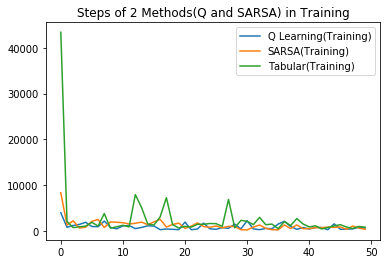

In [12]:
w1 = q_climb_hill()
w2 = sarsa_climb_hill()

tabular_steps = [43400, 2018, 693, 869, 1026, 1850, 1032, 3759, 557, 883, 1203, 846, 7914, 5091, 1479, 1247, 3056, 7235, 1349, 598, 967, 801, 1427, 1415, 1593, 1554, 972, 6854, 660, 2271, 2073, 1348, 2932, 1326, 1462, 462, 2024, 1154, 2662, 1484, 854, 1086, 392, 723, 1061, 1333, 822, 496, 942, 784]

plt.plot(q_train_steps, label="Q Learning(Training)")
plt.plot(sarsa_train_steps, label="SARSA(Training)")
plt.plot(tabular_steps, label="Tabular(Training)")
plt.title("Steps of 2 Methods(Q and SARSA) in Training")
# plt.xlabel('Episodes')
# plt.ylabel('Steps')
plt.legend()
plt.show()

In [13]:
q_step_track = []
for item in range(10):  
    w = q_climb_hill()
    step = test(w)
    q_step_track.append(step)

sarsa_step_track = []
for item in range(10):
    w = sarsa_climb_hill()
    step = test(w)
    sarsa_step_track.append(step)

Q is helping car climb the mountain!
episode: 0, steps cost: 3683
episode: 1, steps cost: 2281
episode: 2, steps cost: 786
episode: 3, steps cost: 1713
episode: 4, steps cost: 1236
episode: 5, steps cost: 1318
episode: 6, steps cost: 1250
episode: 7, steps cost: 309
episode: 8, steps cost: 986
episode: 9, steps cost: 952
episode: 10, steps cost: 674
episode: 11, steps cost: 1288
episode: 12, steps cost: 835
episode: 13, steps cost: 697
episode: 14, steps cost: 742
episode: 15, steps cost: 1045
episode: 16, steps cost: 481
episode: 17, steps cost: 479
episode: 18, steps cost: 2165
episode: 19, steps cost: 955
episode: 20, steps cost: 835
episode: 21, steps cost: 982
episode: 22, steps cost: 829
episode: 23, steps cost: 942
episode: 24, steps cost: 464
episode: 25, steps cost: 316
episode: 26, steps cost: 333
episode: 27, steps cost: 241
episode: 28, steps cost: 322
episode: 29, steps cost: 392
episode: 30, steps cost: 264
episode: 31, steps cost: 518
episode: 32, steps cost: 325
episode

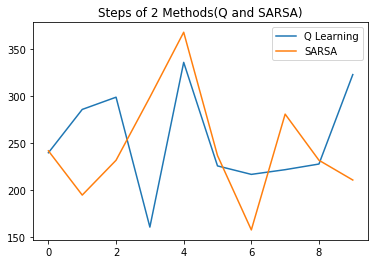

In [14]:
plt.plot(q_step_track, label="Q Learning")
plt.plot(sarsa_step_track, label="SARSA")
plt.title("Steps of 2 Methods(Q and SARSA)")

# plt.xlabel('Episodes')
# plt.ylabel('Steps')
plt.legend()
plt.show()